# UDAの前処理に異常検知を混ぜることでデータセットの多様性を増やす

<h3> まず、既定路線の関数を定義する </h3>
<h4> preprocess.py </h4>

In [1]:
from hyperdash import monitor_cell

In [2]:
#特に前処理について.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import xrange  # pylint: disable=redefined-builtin
import collections
import os
import sys
import cv2
import tarfile
import numpy as np
from tqdm import tqdm
from absl import flags
import absl.logging as _logging  # pylint: disable=unused-import
import scipy.io
import tensorflow as tf
from randaugment import policies as found_policies
from randaugment import augmentation_transforms

In [3]:
#特に異常検知の文脈において.
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
import numpy as np
from tqdm import tqdm
import os
import pickle
import statistics
import matplotlib.pyplot as plt
import random
import warnings
from PIL import Image
import seaborn as sns
warnings.simplefilter('ignore')

In [4]:
#デバイスの確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cuda:0


In [5]:
CIFAR_TARNAME = "cifar-10-python.tar.gz"
CIFAR_DOWNLOAD_URL = "https://www.cs.toronto.edu/~kriz/" + CIFAR_TARNAME
SVHN_DOWNLOAD_URL = "http://ufldl.stanford.edu/housenumbers/{}_32x32.mat"

DOWNLOAD_DATA_FOLDER = "downloaded_data"
MERGE_DATA_FOLDER = "merged_raw_data"

random_seed = np.random.randint(0, 10000)

In [6]:
def format_sup_filename(split, sup_size=-1):
  if split == "test":
    return "test.tfrecord"
  elif split == "train" or split == "dev":
    if sup_size == -1:
      return "{}-full.tfrecord".format(split, sup_size)
    else:
      return "{}-size_{:d}.tfrecord".format(split, sup_size)

def format_unsup_filename(aug_copy_num):
  return "unsup-{:d}.tfrecord".format(aug_copy_num)


def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list(value)))


def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=list(value)))


def get_raw_data_filenames(split):
    if split == "train":
        return ["data_batch_%d" % i for i in xrange(1, 6)]
    elif split == "test":
      return ["test_batch"]
    else:
        assert False


def read_pickle_from_file(filename):
  with tf.gfile.Open(filename, "rb") as f:
    if sys.version_info >= (3, 0):
      data_dict = pickle.load(f, encoding="bytes")
    else:
      data_dict = pickle.load(f)
  return data_dict


def obtain_tfrecord_writer(out_path, shard_cnt):
  tfrecord_writer = tf.python_io.TFRecordWriter(
      "{}.{:d}".format(out_path, shard_cnt))
  return tfrecord_writer


def save_tfrecord(example_list, out_path, max_shard_size=4096):
  shard_cnt = 0
  shard_size = 0
  record_writer = obtain_tfrecord_writer(out_path, shard_cnt)
  for example in example_list:
    if shard_size >= max_shard_size:
      record_writer.close()
      shard_cnt += 1
      record_writer = obtain_tfrecord_writer(out_path, shard_cnt)
      shard_size = 0
    shard_size += 1
    record_writer.write(example.SerializeToString())
  record_writer.close()
  tf.logging.info("saved {} examples to {}".format(len(example_list), out_path))


def save_merged_data(images, labels, split, merge_folder):
  with tf.gfile.Open(
      os.path.join(merge_folder, "{}_images.npy".format(split)), "wb") as ouf:
    np.save(ouf, images)
  with tf.gfile.Open(
      os.path.join(merge_folder, "{}_labels.npy".format(split)), "wb") as ouf:
    np.save(ouf, labels)

<h3> 次に、download_and_extract関数を行ごとに実行して様子を見つつ、可能そうならデータのオーグメンテーションをしてみる </h3>

In [7]:
all_exist = True
download_folder = os.path.join(DOWNLOAD_DATA_FOLDER)
merge_folder = os.path.join(MERGE_DATA_FOLDER)
for split in ["train", "test"]:
    for field in ["images", "labels"]:
        if not tf.gfile.Exists(os.path.join(merge_folder, "{}_{}.npy".format(split, field))):
            all_exist = False
if all_exist:
    tf.logging.info("found all merged files")
print('all_exist:' + str(all_exist))
tf.logging.info("downloading dataset")
tf.gfile.MakeDirs(download_folder)
tf.gfile.MakeDirs(merge_folder)

INFO:tensorflow:found all merged files
all_exist:True
INFO:tensorflow:downloading dataset


In [8]:
#if FLAGS.task_name == 'cifar10'以下の話
tf.contrib.learn.datasets.base.maybe_download(
    CIFAR_TARNAME, download_folder, CIFAR_DOWNLOAD_URL)
tarfile.open(os.path.join(download_folder, CIFAR_TARNAME), "r:gz").extractall(download_folder)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please write your own downloading logic.


In [9]:
for split in ["train", "test"]:
    images_list = []
    labels_list = []
    for filename in get_raw_data_filenames(split):
        cur_data = read_pickle_from_file(
            os.path.join(download_folder, "cifar-10-batches-py", filename))
        labels_list += [cur_data[b"labels"]]
        images_list += [cur_data[b"data"]]
    images = np.concatenate(images_list, 0)
    labels = np.concatenate(labels_list, 0)
    images = images.reshape([-1, 3, 32, 32])
    images = images.transpose(0, 2, 3, 1)
    save_merged_data(images, labels, split, merge_folder)

In [10]:
#dataのtrainとtestをそれぞれimagesとlabelsに分けて作る.
def load_dataset():
    data = {}
    merge_folder = os.path.join(MERGE_DATA_FOLDER)
    for split in ["train", "test"]:
        with tf.gfile.Open(
            os.path.join(merge_folder, "{}_images.npy".format(split)), 'rb') as inf:
            images = np.load(inf)
        with tf.gfile.Open(
            os.path.join(merge_folder, "{}_labels.npy".format(split)), 'rb') as inf:
            labels = np.load(inf)
        data[split] = {"images":images, "labels":labels}
    return data

In [11]:
#多分iterableにimageとlabelを取り出す.最後まで, 可能な限り
def get_data_by_size_lim(images, labels, sup_size, return_rest=False):
    chosen_images = images[:sup_size]
    chosen_labels = labels[:sup_size]
    rest_images = images[sup_size:]
    rest_labels = labels[sup_size:]
    if return_rest:
        return chosen_images, chosen_labels, rest_images, rest_labels

In [12]:
def process_and_save_sup_data(chosen_images, chosen_labels, split, sup_size=-1):
    chosen_images = chosen_images / 255.0
    mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
    chosen_images = (chosen_images - mean) / std
    example_list = []
    for image, label in zip(chosen_images, chosen_labels):
        example = tf.train.Example(features=tf.train.Features(
            feature={
                "image": _float_feature(image.reshape(-1)),
                "label": _int64_feature(label.reshape(-1))
            }))
        example_list += [example]
    out_path = os.path.join(output_base_dir, format_sup_filename(split, sup_size))
    tf.logging.info(">>saving {} {} examples to {}".format(len(example_list), split, out_path))
    save_tfrecord(example_list, out_path)

In [13]:
def proc_and_dump_sup_data(sub_set_data, split, sup_size=-1):
    images = sub_set_data["images"]
    labels = sub_set_data["labels"]
    if sup_size != -1:
        chosen_images, chosen_labels = get_data_by_size_lim(
            images, labels, sup_size)
    else:
        chosen_images = images
        chosen_labels = labels
    process_and_save_sup_data(chosen_images, chosen_labels, split)

In [14]:
#augmentation_transforms.apply_policy, cutout_numpyについて考える.

In [15]:
#unsupervised dataのみをrand augmentする.
def proc_and_dump_unsup_data(sub_set_data, aug_copy_num):
    ori_images = sub_set_data["images"].copy()
    image_idx = np.arange(len(ori_images))
    np.random.shuffle(image_idx)
    ori_images = ori_images[image_idx]
    ori_images = ori_images / 255.0
    mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
    ori_images = (ori_images - mean) / std
    aug_policies = found_policies.randaug_policies()
    example_list = []
    for image in ori_images:
        chosen_policy = aug_policies[np.random.choice(
            len(aug_policies))]
        #この段階で, chosen_policyは2個の要素を持っている.
        aug_image = augmentation_transforms.apply_policy(
            chosen_policy, image)
        aug_image = augmentation_transforms.cutout_numpy(aug_image)
        #ここで条件式を投げて, aug_imageが一定の閾値以下であれば3回目のaugmentationを加える.
        example = tf.train.Example(features=tf.train.Features(
            feature={
                "ori_image": _float_feature(image.reshape(-1)),
                "aug_image": _float_feature(aug_image.reshape(-1)),
            }))
        example_list += [example]
    out_path = os.path.join(output_base_dir, format_unsup_filename(aug_copy_num),)
    save_tfrecord(example_list, out_path)

In [16]:
def indices_maker():
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215841, 0.44653091),
                             (0.24703223, 0.24348513, 0.26158784))]
    )
    trainset = torchvision.datasets.CIFAR10(root="./data",
                                            train=True, download=True,
                                            transform=transform)
    aircraft_indices, car_indices, bird_indices, cat_indices, deer_indices = [], [], [], [], []
    dog_indices, frog_indices, horse_indices, ship_indices, truck_indices = [], [], [], [], []
    i = 0
    #aircraft_indicesにlabelが0(=飛行機)の画像のindexを入れる.
    for tensor in tqdm(trainset):
        if tensor[1] == 0:
            aircraft_indices.append(i)
        if tensor[1] == 1:
            car_indices.append(i)
        if tensor[1] == 2:
            bird_indices.append(i)
        if tensor[1] == 3:
            cat_indices.append(i)
        if tensor[1] == 4:
            deer_indices.append(i)
        if tensor[1] == 5:
            dog_indices.append(i)
        if tensor[1] == 6:
            frog_indices.append(i)
        if tensor[1] == 7:
            horse_indices.append(i)
        if tensor[1] == 8:
            ship_indices.append(i)
        if tensor[1] == 9:
            truck_indices.append(i)
        i += 1
    return aircraft_indices, car_indices, bird_indices, cat_indices, deer_indices, dog_indices, frog_indices, horse_indices, ship_indices, truck_indices
aircraft_indices, car_indices, bird_indices, cat_indices, deer_indices, dog_indices, frog_indices, horse_indices, ship_indices, truck_indices = indices_maker()

Files already downloaded and verified


100%|██████████| 50000/50000 [00:08<00:00, 5848.55it/s]


In [17]:
#今回は, cifar10のすべてのデータに対してAnoGANを学習させる.
def load_datasets():
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215841, 0.44653091),
                             (0.24703223, 0.24348513, 0.26158784))]
    )
    trainset = torchvision.datasets.CIFAR10(root="./data",
                                            train=True, download=True,
                                            transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                               shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                               sampler=SubsetRandomSampler(car_indices), num_workers=4)
    return train_loader, test_loader

In [18]:
data = load_dataset()

In [19]:
ori_images = data["train"]["images"].copy()
image_idx = np.arange(256)
ori_images = ori_images / 255.0
mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
ori_images = (ori_images - mean) / std
aug_policies = found_policies.randaug_policies()
aug_image_list = torch.randn(256, 3, 32, 32)
i=0
for image in ori_images:
    chosen_policy = aug_policies[np.random.choice(len(aug_policies))]
    aug_image = augmentation_transforms.apply_policy(chosen_policy, image)
    aug_image = augmentation_transforms.cutout_numpy(aug_image)
    aug_image_list[i] = torch.from_numpy(aug_image.transpose(2, 0, 1))
    i+=1
    if i>=256:
        break

INFO:tensorflow:trans_list: ['Invert', 'Cutout', 'Sharpness', 'AutoContrast', 'Posterize', 'ShearX', 'TranslateX', 'TranslateY', 'ShearY', 'Rotate', 'Equalize', 'Contrast', 'Color', 'Solarize', 'Brightness']


In [20]:
default_list = torch.randn(256, 3, 32, 32)
for i in range(len(default_list)):
    default_list[i] = torch.from_numpy(ori_images[i].transpose(2, 0, 1))

In [21]:
train_loader, test_loader = load_datasets()

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


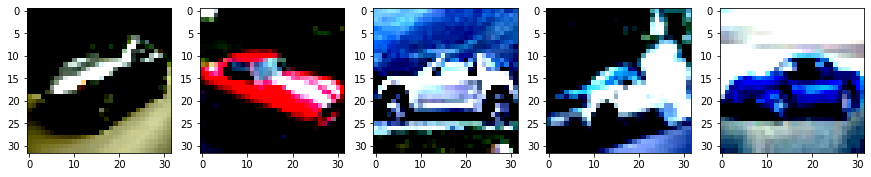

In [22]:
batch_iterator = iter(test_loader)
imges = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[0][i].numpy().reshape(3, 32, 32).transpose(1, 2, 0));

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=256,
                               kernel_size=4, stride=1, padding=0), # 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128,
                               kernel_size=2, stride=2, padding=0), #8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=2, stride=2, padding=0), #16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, 
                               kernel_size=2, stride=2, padding=0), #32x32
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer2 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer3 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True))

        self.layer4 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))

        self.last = nn.Sequential(
            nn.AvgPool2d(4),
            nn.Conv2d(256, 1, 1)) # fcの代わり

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        feature = out
        feature = feature.view(feature.size()[0], -1)
        out = self.last(out)
        return out, feature

In [25]:
def train():
    # モデル
    model_G, model_D = Generator(), Discriminator()
    model_G, model_D = nn.DataParallel(model_G), nn.DataParallel(model_D)
    model_G, model_D = model_G.to(device), model_D.to(device)

    params_G = torch.optim.Adam(model_G.parameters(),
                lr=0.0002, betas=(0.5, 0.999))
    params_D = torch.optim.Adam(model_D.parameters(),
                lr=0.0002, betas=(0.5, 0.999))
    
    # ロスを計算するためのラベル変数
    ones = torch.ones(256, 1, 1, 1).to(device)
    zeros = torch.zeros(256, 1, 1, 1).to(device)
    loss_f = nn.BCEWithLogitsLoss()

    # エラー推移
    result = {}
    result["log_loss_G"] = []
    result["log_loss_D"] = []

    # 訓練
    dataset, test_dataset = load_datasets()
    for i in range(300):
        log_loss_G, log_loss_D = [], []
        for real_img in tqdm(dataset):
            real_img = real_img[0]
            batch_len = len(real_img)
            # Gの訓練
            # 偽画像を作成
            z = torch.randn(batch_len, 128, 1, 1).to(device)
            fake_img = model_G(z)

            # 偽画像を一時保存
            fake_img_tensor = fake_img.detach()

            # 偽画像を本物と騙せるようにロスを計算
            out, _ = model_D(fake_img)
            loss_G = loss_f(out, ones[:batch_len])
            log_loss_G.append(loss_G.item())

            # 微分計算・重み更新
            params_D.zero_grad()
            params_G.zero_grad()
            loss_G.backward()
            params_G.step()

            # Discriminatoの訓練
            # sample_dataの実画像
            real_img = real_img.to(device)
            # 実画像を実画像と識別できるようにロスを計算
            real_out, _ = model_D(real_img)
            loss_D_real = loss_f(real_out, ones[:batch_len])

            # 偽の画像の偽と識別できるようにロスを計算
            fake_out, _ = model_D(fake_img_tensor)
            loss_D_fake = loss_f(fake_out, zeros[:batch_len])

            # 実画像と偽画像のロスを合計
            loss_D = loss_D_real + loss_D_fake
            log_loss_D.append(loss_D.item())

            # 微分計算・重み更新
            params_D.zero_grad()
            params_G.zero_grad()
            loss_D.backward()
            params_D.step()

        result["log_loss_G"].append(statistics.mean(log_loss_G))
        result["log_loss_D"].append(statistics.mean(log_loss_D))
        print("log_loss_G =", result["log_loss_G"][-1], ", log_loss_D =", result["log_loss_D"][-1])
        print("Epoch" + str(i) + "done.")
        # 画像を保存
        if not os.path.exists("cifar_generated"):
            os.mkdir("cifar_generated")
        torchvision.utils.save_image(fake_img_tensor[:min(batch_len, 100)],
                                f"cifar_generated/epoch_{i:03}.png")
    # ログの保存
    with open("cifar_generated/logs.pkl", "wb") as fp:
        pickle.dump(result, fp)
    return model_G, model_D

In [26]:
%%monitor_cell "train_phase"
G_update, D_update = train()

  0%|          | 0/196 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 0.9186807204874194 , log_loss_D = 1.0706058655466353
Epoch0done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 0.883018224215021 , log_loss_D = 1.1427072079814211
Epoch1done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 0.8669224795030088 , log_loss_D = 1.170315109649483
Epoch2done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 0.9116135166615856 , log_loss_D = 1.1260217014624148
Epoch3done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 0.9515178969928196 , log_loss_D = 1.0877249097945738
Epoch4done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 0.9945230432310883 , log_loss_D = 1.0494755062521721
Epoch5done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.0396105169641727 , log_loss_D = 1.016886062768041
Epoch6done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.075928085008446 , log_loss_D = 0.9783542846538582
Epoch7done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.1288915160967379 , log_loss_D = 0.9385046983251766
Epoch8done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.1884270041268699 , log_loss_D = 0.8933827925701531
Epoch9done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.2330486376066596 , log_loss_D = 0.8581318833998272
Epoch10done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.2597317142145974 , log_loss_D = 0.8473961861157904
Epoch11done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.327646290465277 , log_loss_D = 0.7975706750032853
Epoch12done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.3691021824369625 , log_loss_D = 0.7720302615542801
Epoch13done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.4136316697208249 , log_loss_D = 0.7563107608228313
Epoch14done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.4634023372616087 , log_loss_D = 0.7144335300034407
Epoch15done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.4948825833140587 , log_loss_D = 0.7007138332238003
Epoch16done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.5609337608424985 , log_loss_D = 0.6595012574475638
Epoch17done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.5802737808957392 , log_loss_D = 0.6656581995134451
Epoch18done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.6316043679811516 , log_loss_D = 0.6218963511744324
Epoch19done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.6687808584193795 , log_loss_D = 0.6259724297085587
Epoch20done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.6824182694663807 , log_loss_D = 0.6057713027207219
Epoch21done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.7570175806782684 , log_loss_D = 0.5815031648594506
Epoch22done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.762907290337037 , log_loss_D = 0.5720249677495081
Epoch23done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.7981934042609469 , log_loss_D = 0.5597601894821439
Epoch24done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.899383263320339 , log_loss_D = 0.5035283913721844
Epoch25done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.8910228190373402 , log_loss_D = 0.5304651141774898
Epoch26done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.8882692912403418 , log_loss_D = 0.552151192055673
Epoch27done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.9217050039038366 , log_loss_D = 0.5329248824593972
Epoch28done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 1.9640855904744596 , log_loss_D = 0.4956701962771464
Epoch29done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.024999644683332 , log_loss_D = 0.46467489901245856
Epoch30done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.03701088410251 , log_loss_D = 0.47641026129832076
Epoch31done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.003021692743107 , log_loss_D = 0.5196518073124545
Epoch32done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.110731654781468 , log_loss_D = 0.4297027927728332
Epoch33done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.099290649501645 , log_loss_D = 0.4542165550650383
Epoch34done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.137371983759257 , log_loss_D = 0.46489677380542366
Epoch35done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.095933593353447 , log_loss_D = 0.54901988127706
Epoch36done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.155742313180651 , log_loss_D = 0.4078543760946819
Epoch37done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.1894539767230046 , log_loss_D = 0.4616505666350832
Epoch38done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.2567485461429673 , log_loss_D = 0.39753897434898783
Epoch39done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.246327339538506 , log_loss_D = 0.43044129394146863
Epoch40done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.184036421000349 , log_loss_D = 0.506334628149563
Epoch41done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.3335923289462013 , log_loss_D = 0.3814707516255427
Epoch42done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.292486832230067 , log_loss_D = 0.42796324862509355
Epoch43done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.3219248637252923 , log_loss_D = 0.4077820330097967
Epoch44done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.2567974884747244 , log_loss_D = 0.49311865562078905
Epoch45done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.462495898409766 , log_loss_D = 0.32518317770897126
Epoch46done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.350616058524774 , log_loss_D = 0.49815154535581874
Epoch47done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.3024670802512945 , log_loss_D = 0.41020363470425414
Epoch48done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.42124702357592 , log_loss_D = 0.4048444800535027
Epoch49done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.3923232322368695 , log_loss_D = 0.40617069092636204
Epoch50done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.408948745958659 , log_loss_D = 0.4044584476065879
Epoch51done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.456946739584816 , log_loss_D = 0.38857702348305256
Epoch52done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.5035474931403083 , log_loss_D = 0.3688258437857944
Epoch53done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.477080441707251 , log_loss_D = 0.39043724745968167
Epoch54done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.522540901692546 , log_loss_D = 0.32984607738955896
Epoch55done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.470246828332239 , log_loss_D = 0.4205628692799685
Epoch56done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.5077705463128432 , log_loss_D = 0.3597500725668304
Epoch57done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.4666573804404055 , log_loss_D = 0.40035137853452135
Epoch58done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.62411510062461 , log_loss_D = 0.29993301341120077
Epoch59done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.5537864438125064 , log_loss_D = 0.37156404072076693
Epoch60done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.559001395973016 , log_loss_D = 0.3913135059481981
Epoch61done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.5165476011378423 , log_loss_D = 0.36901713033415834
Epoch62done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.624089494575651 , log_loss_D = 0.31823562036211395
Epoch63done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.6652877809745923 , log_loss_D = 0.3323500894238146
Epoch64done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.490516738928094 , log_loss_D = 0.4296137953975371
Epoch65done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.71264226552175 , log_loss_D = 0.3087965807288277
Epoch66done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.555774693282283 , log_loss_D = 0.4229816287299808
Epoch67done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7929182411456597 , log_loss_D = 0.24717144485639067
Epoch68done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.6264007964304517 , log_loss_D = 0.4231924559845
Epoch69done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.671081597555657 , log_loss_D = 0.3268266467719662
Epoch70done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7660015728704783 , log_loss_D = 0.2796542623593491
Epoch71done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.6787321250505594 , log_loss_D = 0.3674390974397562
Epoch72done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.719487521417287 , log_loss_D = 0.3358399747509737
Epoch73done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7541041429705766 , log_loss_D = 0.33729530863311824
Epoch74done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7917314589935907 , log_loss_D = 0.2827533451003992
Epoch75done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.54446218474483 , log_loss_D = 0.4667046925014987
Epoch76done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.695345645200233 , log_loss_D = 0.38102635288877146
Epoch77done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.755788990277417 , log_loss_D = 0.32654068033610073
Epoch78done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7326521694051977 , log_loss_D = 0.401803332856115
Epoch79done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7366065708350162 , log_loss_D = 0.34421214875670114
Epoch80done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7998772912031535 , log_loss_D = 0.298238304462664
Epoch81done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.93783642731759 , log_loss_D = 0.24352748840287022
Epoch82done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.717392328784478 , log_loss_D = 0.4040452899905492
Epoch83done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.857547184376388 , log_loss_D = 0.34426826284248
Epoch84done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7374790126875954 , log_loss_D = 0.3452593229559003
Epoch85done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9818989598021215 , log_loss_D = 0.2355375137864327
Epoch86done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0654376787798747 , log_loss_D = 0.19898901811363745
Epoch87done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.704811238132569 , log_loss_D = 0.4511878525990309
Epoch88done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.633231231752707 , log_loss_D = 0.5188563676665023
Epoch89done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.8249636148007546 , log_loss_D = 0.31209095639689843
Epoch90done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.8333914298184064 , log_loss_D = 0.3225810393995168
Epoch91done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.8350233095032826 , log_loss_D = 0.3660463896599047
Epoch92done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.890508943522463 , log_loss_D = 0.3318620913719036
Epoch93done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.775672494718919 , log_loss_D = 0.3752029334213965
Epoch94done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9516051064188384 , log_loss_D = 0.23539116214580683
Epoch95done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0427469985217463 , log_loss_D = 0.2613021394960126
Epoch96done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.890440191009215 , log_loss_D = 0.32486252828824275
Epoch97done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.750490387027361 , log_loss_D = 0.41616593153044884
Epoch98done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.8565666705217896 , log_loss_D = 0.3770424393290768
Epoch99done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0104036252109374 , log_loss_D = 0.27808269550453646
Epoch100done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9522008972280487 , log_loss_D = 0.3130007031924871
Epoch101done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.01152066430267 , log_loss_D = 0.23322517481841604
Epoch102done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0073840786912003 , log_loss_D = 0.29071965718603865
Epoch103done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0407454309871 , log_loss_D = 0.26463225521907513
Epoch104done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0746496157074463 , log_loss_D = 0.2521033690938232
Epoch105done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9678572729534034 , log_loss_D = 0.34795661772392233
Epoch106done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1504340389629406 , log_loss_D = 0.3066384340161268
Epoch107done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.691586862565303 , log_loss_D = 0.4177533888010954
Epoch108done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3073146513530185 , log_loss_D = 0.14122022236032145
Epoch109done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.6707920437412604 , log_loss_D = 0.46519644529919846
Epoch110done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9109013613541515 , log_loss_D = 0.35794273087260675
Epoch111done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1673545449668046 , log_loss_D = 0.23365210314110227
Epoch112done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.140043734439782 , log_loss_D = 0.23400530918520324
Epoch113done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0731710550584355 , log_loss_D = 0.3367702199754362
Epoch114done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.300105222025696 , log_loss_D = 0.1385631651370501
Epoch115done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7070949181762276 , log_loss_D = 0.5491377263500983
Epoch116done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0096345927034105 , log_loss_D = 0.2781379802190528
Epoch117done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.90046063871408 , log_loss_D = 0.36881024698365705
Epoch118done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0719632243319435 , log_loss_D = 0.31203084821071553
Epoch119done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0949376245238343 , log_loss_D = 0.25730637588291144
Epoch120done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2664051335685107 , log_loss_D = 0.1764565914945335
Epoch121done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.031744081298916 , log_loss_D = 0.3449481588085087
Epoch122done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1205188872254626 , log_loss_D = 0.24888303959552122
Epoch123done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1017074734162615 , log_loss_D = 0.3112715973841901
Epoch124done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1186167308110364 , log_loss_D = 0.29815453775607204
Epoch125done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2951015544180966 , log_loss_D = 0.1867776809222236
Epoch126done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2403229091848647 , log_loss_D = 0.3121403996091412
Epoch127done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9078976324930483 , log_loss_D = 0.3196559345387683
Epoch128done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.0795007395957197 , log_loss_D = 0.3061925789949541
Epoch129done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2146015738194085 , log_loss_D = 0.36175628835145307
Epoch130done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9064405479905555 , log_loss_D = 0.3218909379246892
Epoch131done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2894474067250075 , log_loss_D = 0.21675270117287124
Epoch132done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.6172106080517477 , log_loss_D = 0.6299208342192733
Epoch133done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.120213504652588 , log_loss_D = 0.2648635948913134
Epoch134done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2692539375655505 , log_loss_D = 0.15664093048140712
Epoch135done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.337043177868639 , log_loss_D = 0.23418267219498448
Epoch136done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.185736023991996 , log_loss_D = 0.3446437375315902
Epoch137done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1586106931980775 , log_loss_D = 0.2832851756212054
Epoch138done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.964036845697128 , log_loss_D = 0.39355849009007215
Epoch139done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.576415762609365 , log_loss_D = 0.6889459255664628
Epoch140done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.7457728201941567 , log_loss_D = 0.44231392758689364
Epoch141done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3533556969190133 , log_loss_D = 0.17592271430683987
Epoch142done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.394597118910478 , log_loss_D = 0.1849532646640223
Epoch143done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.439641109078514 , log_loss_D = 0.20281831127572425
Epoch144done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2468184772878885 , log_loss_D = 0.3008285596662638
Epoch145done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4243136909125105 , log_loss_D = 0.29048510152390417
Epoch146done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.9875271473155944 , log_loss_D = 0.34568512812256813
Epoch147done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2801297981368034 , log_loss_D = 0.21674542569992494
Epoch148done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.148228505892413 , log_loss_D = 0.3379084653772262
Epoch149done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3725693739798603 , log_loss_D = 0.1871838962887319
Epoch150done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4181453962715302 , log_loss_D = 0.22069372704290613
Epoch151done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3464378532858525 , log_loss_D = 0.3228062317725651
Epoch152done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1434879892942855 , log_loss_D = 0.262733087190712
Epoch153done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6575718947819302 , log_loss_D = 0.10465002014320723
Epoch154done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.211512468755245 , log_loss_D = 0.3897119738465669
Epoch155done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.552202691381075 , log_loss_D = 0.6337506740487048
Epoch156done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 2.733588837011128 , log_loss_D = 0.46324506968411866
Epoch157done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4594706908172492 , log_loss_D = 0.18842852970927346
Epoch158done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.369602380358443 , log_loss_D = 0.23861618191764064
Epoch159done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.310563478314755 , log_loss_D = 0.2331634456557887
Epoch160done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1653161226030515 , log_loss_D = 0.3563730889475163
Epoch161done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2633744994824636 , log_loss_D = 0.26197108259538604
Epoch162done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3994994022104206 , log_loss_D = 0.2633928966005238
Epoch163done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2856911115196286 , log_loss_D = 0.2587561014925643
Epoch164done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5453933556469117 , log_loss_D = 0.11823004001409423
Epoch165done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1424944330082862 , log_loss_D = 0.36425089001731603
Epoch166done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.451443102438839 , log_loss_D = 0.24763088795945656
Epoch167done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4693540315029723 , log_loss_D = 0.19470772641349812
Epoch168done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.696980660667225 , log_loss_D = 0.09741826293685911
Epoch169done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.363798646104275 , log_loss_D = 0.312375194088993
Epoch170done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2922582700088316 , log_loss_D = 0.2546183265821666
Epoch171done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2857989794289577 , log_loss_D = 0.2769850547786574
Epoch172done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3146374701541297 , log_loss_D = 0.2844838650174895
Epoch173done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.569391689130238 , log_loss_D = 0.1517716428188949
Epoch174done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5243487691848863 , log_loss_D = 0.201223999584968
Epoch175done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.156069184292336 , log_loss_D = 0.451107632596882
Epoch176done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.076747638496513 , log_loss_D = 0.3248170443563437
Epoch177done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4429943120601227 , log_loss_D = 0.20148934395413617
Epoch178done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3555804325305685 , log_loss_D = 0.2501432833889005
Epoch179done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3991062283820037 , log_loss_D = 0.2085914625691212
Epoch180done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6824771095143287 , log_loss_D = 0.15250684050082855
Epoch181done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.26785995355066 , log_loss_D = 0.2826109222535576
Epoch182done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.288958374182789 , log_loss_D = 0.2664757543053402
Epoch183done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3896219690463374 , log_loss_D = 0.26311680349540345
Epoch184done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6724839903870405 , log_loss_D = 0.11833741042610942
Epoch185done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3160895845111535 , log_loss_D = 0.2980314542596437
Epoch186done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4071809730815645 , log_loss_D = 0.3493846798106572
Epoch187done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.309206299483776 , log_loss_D = 0.22457067704550465
Epoch188done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5564810730973067 , log_loss_D = 0.1997991658519117
Epoch189done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.429472302751882 , log_loss_D = 0.2424464436932182
Epoch190done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4467652703692413 , log_loss_D = 0.28700787492324503
Epoch191done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.440312944200574 , log_loss_D = 0.24667276280494976
Epoch192done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3367520893106657 , log_loss_D = 0.24052222390488096
Epoch193done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5509766078725153 , log_loss_D = 0.2180654569433964
Epoch194done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5315929004276287 , log_loss_D = 0.165773977126394
Epoch195done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.449388078052779 , log_loss_D = 0.2522877964514251
Epoch196done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7413805692779776 , log_loss_D = 0.11327669151811576
Epoch197done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4200483012412275 , log_loss_D = 0.2533979931162024
Epoch198done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5344965521208183 , log_loss_D = 0.19250694548293035
Epoch199done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.420152744316325 , log_loss_D = 0.3019460199058664
Epoch200done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.468929571156599 , log_loss_D = 0.20657868934225063
Epoch201done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.1373446814107653 , log_loss_D = 0.36482933914402915
Epoch202done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6598337073715363 , log_loss_D = 0.10677057045644947
Epoch203done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.721473070431729 , log_loss_D = 0.1815549646295151
Epoch204done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5802838093772227 , log_loss_D = 0.18379842706632857
Epoch205done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.134937648642428 , log_loss_D = 0.3994520578381358
Epoch206done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6254489903851432 , log_loss_D = 0.17114255617239646
Epoch207done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.707059861293861 , log_loss_D = 0.18119154677593283
Epoch208done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.557212750978616 , log_loss_D = 0.19598826848692735
Epoch209done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5796981888766193 , log_loss_D = 0.22932870127260685
Epoch210done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.482509903391177 , log_loss_D = 0.2273159734904766
Epoch211done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7350865416989034 , log_loss_D = 0.15013305427582593
Epoch212done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7851496746345443 , log_loss_D = 0.09855818784586629
Epoch213done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6935730538882163 , log_loss_D = 0.2071890838121121
Epoch214done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.388882732090103 , log_loss_D = 0.3114253495040597
Epoch215done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3678901086808466 , log_loss_D = 0.32688153833531
Epoch216done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.326516460095133 , log_loss_D = 0.2758610651125105
Epoch217done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6420836615927366 , log_loss_D = 0.13950689290935286
Epoch218done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.439659809959786 , log_loss_D = 0.230790218262344
Epoch219done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5002054683864117 , log_loss_D = 0.20275856683752974
Epoch220done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.620317074470222 , log_loss_D = 0.191986930024411
Epoch221done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6900887225507475 , log_loss_D = 0.15172426505204367
Epoch222done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.787989433322634 , log_loss_D = 0.21092719056320433
Epoch223done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.375531917475924 , log_loss_D = 0.27106975634791414
Epoch224done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.393941802713944 , log_loss_D = 0.2325960518602206
Epoch225done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6734132045994 , log_loss_D = 0.12501530985975143
Epoch226done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4899750654490624 , log_loss_D = 0.24314763855037033
Epoch227done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6447279450806733 , log_loss_D = 0.26051170604151425
Epoch228done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6123665065922754 , log_loss_D = 0.17183304576165215
Epoch229done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.273824769015215 , log_loss_D = 0.3500792577254529
Epoch230done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5724981325127336 , log_loss_D = 0.15815266966819763
Epoch231done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.79887990318999 , log_loss_D = 0.10864440586455927
Epoch232done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.732980582482961 , log_loss_D = 0.19051630928048066
Epoch233done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.256583499056952 , log_loss_D = 0.400355508303916
Epoch234done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4704245036011754 , log_loss_D = 0.1890397103579373
Epoch235done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.520948841787723 , log_loss_D = 0.2068351900623161
Epoch236done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.018791034209485 , log_loss_D = 0.5401097264482962
Epoch237done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.341698817300553 , log_loss_D = 0.25257900722172794
Epoch238done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2693336130100854 , log_loss_D = 0.25251507017837493
Epoch239done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6358702888294143 , log_loss_D = 0.14227171194720634
Epoch240done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6006117975149228 , log_loss_D = 0.18758531728265238
Epoch241done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.8437079221618418 , log_loss_D = 0.10404562756267129
Epoch242done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.542194509831238 , log_loss_D = 0.26627327180562577
Epoch243done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5571136660113627 , log_loss_D = 0.20512337869565403
Epoch244done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7871557818060473 , log_loss_D = 0.1701003838026402
Epoch245done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4956608225914594 , log_loss_D = 0.2583976582129847
Epoch246done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7591886946133206 , log_loss_D = 0.11404906771126755
Epoch247done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2056587769136744 , log_loss_D = 0.42987946214686545
Epoch248done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5687383139620024 , log_loss_D = 0.1501607827043959
Epoch249done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4507957811571885 , log_loss_D = 0.2561269046320599
Epoch250done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.496436502594425 , log_loss_D = 0.36900608389809425
Epoch251done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4706761265287596 , log_loss_D = 0.22715555933513204
Epoch252done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6230192498436997 , log_loss_D = 0.1668355955305148
Epoch253done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.564723218087943 , log_loss_D = 0.24930045312764693
Epoch254done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.578285928739577 , log_loss_D = 0.1743773818396184
Epoch255done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.3750332491282298 , log_loss_D = 0.26916695887945136
Epoch256done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7945886857199427 , log_loss_D = 0.16928439467613185
Epoch257done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.631736123440217 , log_loss_D = 0.14711551301713502
Epoch258done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.696322635804512 , log_loss_D = 0.20547224079467813
Epoch259done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.9151774109626305 , log_loss_D = 0.09336794350220233
Epoch260done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.627796764010373 , log_loss_D = 0.31700617432290196
Epoch261done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5312128077660287 , log_loss_D = 0.27459271715915934
Epoch262done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.4425812536964613 , log_loss_D = 0.19044495539321582
Epoch263done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.387870111331648 , log_loss_D = 0.2792696385093185
Epoch264done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.77607554744701 , log_loss_D = 0.1389888196860497
Epoch265done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2801588909814554 , log_loss_D = 0.43623493277296727
Epoch266done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.505705469725083 , log_loss_D = 0.15897338413538373
Epoch267done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7920150735548566 , log_loss_D = 0.12079949297809175
Epoch268done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.51582656861568 , log_loss_D = 0.27092583040345686
Epoch269done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.468161512280301 , log_loss_D = 0.2413209199297185
Epoch270done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7138949164322446 , log_loss_D = 0.1132107127876002
Epoch271done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.63131596999509 , log_loss_D = 0.2370376835710236
Epoch272done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6252525073989315 , log_loss_D = 0.16923375646298638
Epoch273done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.8468653698242745 , log_loss_D = 0.17145935802397375
Epoch274done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7142906840890646 , log_loss_D = 0.1648722539028647
Epoch275done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.8008422274522635 , log_loss_D = 0.15868335078489415
Epoch276done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.903962081944456 , log_loss_D = 0.15534670174844106
Epoch277done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.496488775221669 , log_loss_D = 0.2752484310209295
Epoch278done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5049847753680483 , log_loss_D = 0.21464997752360543
Epoch279done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.660827469460818 , log_loss_D = 0.1620989471331847
Epoch280done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6136402947714132 , log_loss_D = 0.22303780276632432
Epoch281done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.899267875418371 , log_loss_D = 0.09085091714728244
Epoch282done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7859687563412043 , log_loss_D = 0.17318567873111793
Epoch283done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.386234593710729 , log_loss_D = 0.3385577843885641
Epoch284done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6562633369954263 , log_loss_D = 0.20761952494100042
Epoch285done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6656484521773396 , log_loss_D = 0.16609182199273181
Epoch286done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.677854873924231 , log_loss_D = 0.18364867666850285
Epoch287done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6500194292819623 , log_loss_D = 0.21896116464037677
Epoch288done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.2499285160126736 , log_loss_D = 0.38992101647796074
Epoch289done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.5538704310144698 , log_loss_D = 0.15652452310433193
Epoch290done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.8281055378670596 , log_loss_D = 0.11818110140762766
Epoch291done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.6449071964895237 , log_loss_D = 0.23126573151699742
Epoch292done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.816442700673123 , log_loss_D = 0.1391095745624328
Epoch293done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.8092976206419418 , log_loss_D = 0.09747367785597334
Epoch294done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.71216603611805 , log_loss_D = 0.18277615514983023
Epoch295done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.8247966875645276 , log_loss_D = 0.15496107012185514
Epoch296done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.562353696141924 , log_loss_D = 0.24147536177948423
Epoch297done.


  0%|          | 0/196 [00:00<?, ?it/s]

log_loss_G = 3.7829352197408372 , log_loss_D = 0.16069433051256501
Epoch298done.


100%|##########| 196/196 [00:11<00:00, 17.81it/s]

log_loss_G = 3.6884964205780806 , log_loss_D = 0.20243081342124816
Epoch299done.
This run of "train_phase" ran for 0:55:33 and logs are available locally at: /home/nomoto/.hyperdash/logs/train-phase/train-phase_2019-11-25t09-13-49-635698.log


In [27]:
def Anormaly_score(x, fake_img, D, Lambda=0.1):
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss, discrimination_loss

In [28]:
#imgesは車の画像

x = imges[0][0:256]
x = x.to(device)
z = torch.randn(256, 128).to(device) #乱数を指定
z = z.view(z.size(0), z.size(1), 1, 1)
z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, residual_loss, discrimination_loss = Anormaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))
        print(torch.sum(discrimination_loss))

epoch 0 || loss_total:723268 
tensor(608686.6250, device='cuda:0', grad_fn=<SumBackward0>)
epoch 1000 || loss_total:491160 
tensor(465578.1562, device='cuda:0', grad_fn=<SumBackward0>)
epoch 2000 || loss_total:454486 
tensor(424311.2188, device='cuda:0', grad_fn=<SumBackward0>)
epoch 3000 || loss_total:433975 
tensor(399352.9375, device='cuda:0', grad_fn=<SumBackward0>)
epoch 4000 || loss_total:416404 
tensor(376548.9688, device='cuda:0', grad_fn=<SumBackward0>)
epoch 5000 || loss_total:405097 
tensor(360743.6250, device='cuda:0', grad_fn=<SumBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total loss： [1355. 1547. 1331. 1377. 1290. 1451. 1271. 1395. 1707. 1314. 1706. 1332.
 1418. 1341. 2279. 2242. 1251. 1938. 1622.  927. 1715. 1196. 1617. 1152.
 1477. 1536. 1778. 1216. 1139. 1175. 1425. 1292. 1040. 1860. 1707. 1098.
 1750. 1349. 1161. 2048. 1416. 1247. 1164. 1902. 1231. 2055. 1485. 1214.
 1460. 1449. 1381. 1463. 1814. 1169. 2101. 1391. 1291. 1966. 1606. 1384.
 1622. 1455. 1534. 1276. 1157. 1320. 1702. 1560. 1276. 1046. 1661. 2111.
 1498. 1026. 1498. 1316. 1910. 2531. 1435. 1451. 1803. 1829. 1675. 1254.
 1782. 1070. 1883. 1647. 1921. 1715. 1536. 1189. 1899. 1705. 1449. 1609.
 1766. 1587. 1850. 1645. 1484. 1344. 2067. 1751. 1214. 1006. 1976. 1335.
 1429. 1399. 3374. 1427. 1888. 1260. 1318. 1652. 2392. 1736. 1138. 1533.
 1465. 1569. 1697. 1883. 1352. 1594. 1420. 1448. 1956. 1665. 1352. 1978.
 1785. 1968. 1244. 1356. 1290. 2034. 1527. 1501. 1480. 1847. 1653. 1730.
 1388. 1457. 1015. 1844. 1368. 1845. 1945. 1790. 1446. 1530. 1465. 1252.
 1389. 1573. 1697. 1678. 1192. 2086. 15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


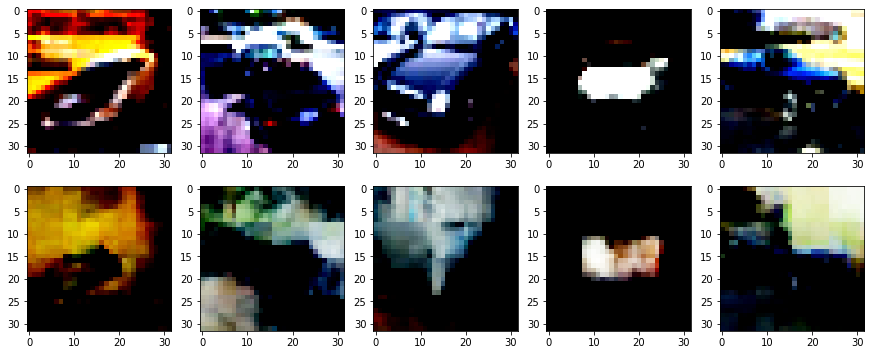

In [29]:
# 画像を生成
fake_img = G_update(z)

# 損失を求める
loss, loss_each, residual_loss, discrimination_loss = Anormaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[0][i+5].cpu().detach().numpy().reshape(3, 32, 32).transpose(1, 2, 0))

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i+5].cpu().detach().numpy().transpose(1, 2, 0))
    plt.savefig("notrotcars.png")

In [31]:
total_loss_def = loss
residual_loss_def = residual_loss
discrimination_loss_def = discrimination_loss

In [32]:
x = aug_image_list
x = x.to(device)
z = torch.randn(256, 128).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)
z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, loss_each, residual_loss, discrimination_loss = Anormaly_score(
        x, fake_img, D_update, Lambda=0.1)
    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()
    if epoch%1000 == 0:
        print("undergoing!")
fake_img = G_update(z)
total_loss, loss_each, residual_loss, discrimination_loss = Anormaly_score(x, fake_img, D_update, Lambda=0.1)
discrimination_loss = discrimination_loss.cpu().detach().numpy()
residual_loss = residual_loss.cpu().detach().numpy()
total_loss = loss_each.cpu().detach().numpy()

undergoing!
undergoing!
undergoing!
undergoing!
undergoing!
undergoing!


In [33]:
total_loss_ag = total_loss
residual_loss_ag = residual_loss
discrimination_loss_ag = discrimination_loss

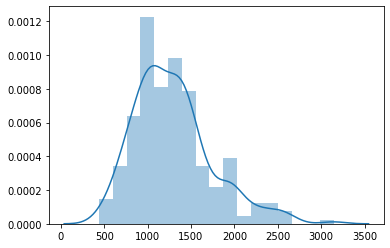

In [34]:
plot = sns.distplot(total_loss_ag)
figure = plot.get_figure()
figure.savefig("disc_loss_ag.png")

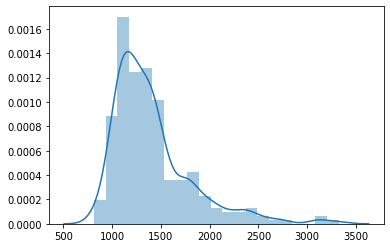

In [36]:
#discrimination lossのプロット
plot = sns.distplot(discrimination_loss_def.cpu().detach().numpy())
figure = plot.get_figure()
figure.savefig("disc_loss_def.png")

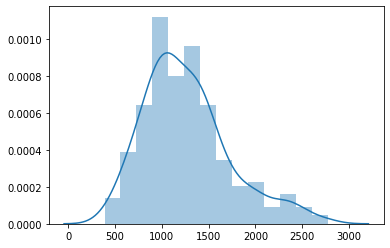

In [37]:
#residual lossのプロット
plot = sns.distplot(residual_loss_ag)
figure = plot.get_figure()
figure.savefig("res_loss_ag.png")

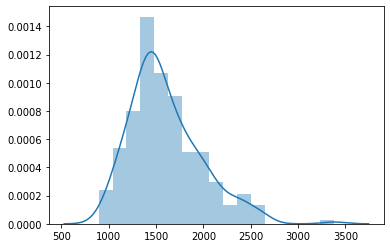

In [39]:
#residual lossのプロット
plot = sns.distplot(residual_loss_def.cpu().detach().numpy())
figure = plot.get_figure()
figure.savefig("res_loss_def.png")

In [55]:
print(np.shape(discrimination_loss_ag))
#discrimination_loss_def = discrimination_loss_def.cpu().detach().numpy()
#residual_loss_def = residual_loss_def.cpu().detach().numpy()
print(np.shape(discrimination_loss_def))

(256,)
(256,)


In [40]:
sns_plot = sns.jointplot(discrimination_loss_ag-discrimination_loss_def, discrimination_loss_ag, kind="reg")
sns_plot.savefig("def_vs_ag.png")

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [57]:
ori_images = data["train"]["images"]
x = torch.from_numpy(ori_images[0:256].transpose(0, 3,1,2))
x = x.to(device)
z = torch.randn(256, 128).to(device) #乱数を指定
z = z.view(z.size(0), z.size(1), 1, 1)
z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, residual_loss, discrimination_loss = Anormaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))
        print(torch.sum(discrimination_loss))

RuntimeError: expected device cuda:0 and dtype Double but got device cuda:0 and dtype Float

In [58]:
output_base_dir = "data/proc_data/cifar10_1122"

In [89]:
#!mkdir "data/proc_data/cifar10_1122"

In [59]:
def randaug_anom(sub_set_data, aug_copy_num):
    ori_images = sub_set_data["images"].copy()
    image_idx = np.arange(len(ori_images))
    np.random.shuffle(image_idx)
    ori_images = ori_images[image_idx]
    ori_images = ori_images / 255.0
    mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
    ori_images = (ori_images - mean) / std
    aug_policies = found_policies.randaug_policies()
    example_list = []
    i, j = 0, 0
    discrimination_losses = np.zeros(50000)
    residual_losses = np.zeros(50000)
    total_losses = np.zeros(50000)
    aug_image_list = torch.randn(256, 3, 32, 32)
    for image in ori_images:
        chosen_policy = aug_policies[np.random.choice(len(aug_policies))]
        aug_image = augmentation_transforms.apply_policy(chosen_policy, image)
        aug_image = augmentation_transforms.cutout_numpy(aug_image)
        example = tf.train.Example(features=tf.train.Features(
            feature={
                "ori_image": _float_feature(image.reshape(-1)),
                "aug_image": _float_feature(aug_image.reshape(-1)),
            }))
        example_list += [example]
        aug_image_list[i] = torch.from_numpy(aug_image.transpose(2, 0, 1))
        i += 1
        if i%100 == 99:
            print("going!")
        if i >= 256:
            x = aug_image_list
            x = x.to(device)
            z = torch.randn(256, 128).to(device)
            z = z.view(z.size(0), z.size(1), 1, 1)
            z.requires_grad = True
            z_optimizer = torch.optim.Adam([z], lr=1e-3)
            for epoch in range(5000+1):
                fake_img = G_update(z)
                loss, _, residual_loss, discrimination_loss = Anormaly_score(
                    x, fake_img, D_update, Lambda=0.1)
                z_optimizer.zero_grad()
                loss.backward()
                z_optimizer.step()
            fake_img = G_update(z)
            total_loss, loss_each, residual_loss, discrimination_loss = Anormaly_score(x, fake_img, D_update, Lambda=0.1)
            discrimination_loss = discrimination_loss.cpu().detach().numpy()
            residual_loss = residual_loss.cpu().detach().numpy()
            total_loss = total_loss.cpu().detach().numpy()
            discrimination_losses[j*256:256+j*256] = discrimination_loss
            residual_losses[j*256:256+j*256] = residual_loss
            total_losses[j*256:256+j*256] = total_loss
            print("total loss：", np.round(discrimination_loss, 0))
            tmp = np.where(discrimination_loss < 1750)[0]
            #1750以下のdiscrimination lossのところは作り直し.
            for k in range(len(tmp)):
                chosen_policy = aug_policies[np.random.choice(len(aug_policies))]
                image = ori_images[tmp[k] + 256*j]
                aug_image_v2 = augmentation_transforms.apply_policy(chosen_policy, image)
                aug_image_v2 = augmentation_transforms.cutout_numpy(aug_image_v2)
                example = tf.train.Example(features=tf.train.Features(
                    feature={
                        "ori_image": _float_feature(image.reshape(-1)),
                        "aug_image": _float_feature(aug_image_v2.reshape(-1)),
                    }))
                example_list[tmp[k] + 256*j] = example
            i = 0
            j += 1
            print(len(example_list))
            aug_image_list = torch.randn(256, 3, 32, 32)
        else:
            pass
    out_path = os.path.join(output_base_dir, format_unsup_filename(aug_copy_num),)
    save_tfrecord(example_list, out_path)
    return total_losses, discrimination_losses, residual_losses

In [ ]:
%%monitor_cell "augmentation_phase"
randaug_anom(data["train"], aug_copy_num = 0)

INFO:tensorflow:trans_list: ['Invert', 'Cutout', 'Sharpness', 'AutoContrast', 'Posterize', 'ShearX', 'TranslateX', 'TranslateY', 'ShearY', 'Rotate', 'Equalize', 'Contrast', 'Color', 'Solarize', 'Brightness']
going!
going!
total loss： [1120.  724. 1811. 2707. 1241. 1347. 2017. 2002. 1138. 1021. 1339. 2132.
 1174. 1677. 1434. 3834. 1176. 1819. 1314. 1524. 1016. 1099.  889. 1085.
 1095. 1083.  897. 1147.  862. 1186. 1012. 1019. 1329. 1369. 1249. 1007.
 1120. 1198. 1656. 1394. 1246.  806. 1168. 1396.  591. 1786. 1846. 1342.
 1306.  954. 1010. 1553. 2095. 1082.  799. 1152. 1513. 1122. 1643. 1116.
 1089. 1316. 1545. 1548.  903. 1763. 1238. 3030. 1213. 1052. 1093. 1011.
  951.  625. 1425. 1130. 1173. 1237. 1084.  884. 1957. 1213. 1300. 2477.
  914. 3611.  926.  840. 1258. 5169. 1474. 1424. 1084.  852. 1589.  760.
 1184.  792. 1192.  851.  967. 1207. 1041.  846.  809. 1255. 1087.  841.
  991.  631.  821. 1009. 2164.  942. 1009. 1148.  894. 1240.  799. 1526.
 1039. 1232.  948. 1264. 3062.  798.

going!
total loss： [2009. 1633. 1180. 1200.  827. 2027.  700. 3439.  869. 1166.  845. 1349.
 1787. 1197. 1409.  789.  573.  806. 1203. 1006.  894. 1178. 1280.  744.
 1402. 1503. 1283.  611.  977. 1186.  876.  754. 1004. 1116.  623. 1282.
 1232.  907. 1376. 1140. 1291. 1129. 2174. 2367.  940.  802. 1142. 1103.
  952.  817. 1027.  940. 1118. 2045. 1244. 1537.  885.  908.  917. 1201.
  825. 1034.  790. 1331.  711. 1401. 1101. 2663. 2777. 1622.  781. 1236.
  989. 1377.  919. 1084.  754. 1486.  952. 1407.  955. 1078. 1129.  722.
  934.  750. 1189.  667.  864. 1200.  891. 1212.  818. 1410.  707. 4695.
 1259.  961. 1660. 1622. 1142. 1025. 1620. 1077. 1253. 1208. 1236.  845.
 1233. 2234.  673. 1167. 1074. 1723. 1604. 1326. 1025. 2683. 2463. 1029.
  701. 1541. 1112. 1255. 1290.  672.  967. 1054. 1424. 3093. 2219. 1178.
 1999.  934. 1781. 1513. 1592. 1571.  974. 2428. 1402.  829. 1000. 1163.
 1127.  971. 1407. 1030. 1074. 1291. 1012. 1415. 1017.  948.  835. 2558.
 1583. 1244. 1667.  968. 1240. 1

3072
going!
going!
total loss： [1569. 1382.  874. 1504. 1224. 1273. 1602. 1180. 1272.  902. 1097.  876.
 1041. 1416. 1373. 1036. 1697. 1032. 1016. 1576. 1014.  972. 1260. 1146.
  836. 1426. 3103.  897.  739. 1220. 1015. 1737. 1266. 1797. 1254. 1270.
 1175. 1430. 1005.  774.  710. 1529. 1472. 1685. 1078. 1319. 1583. 1062.
 2457. 1374. 1206. 1058. 1891. 1352. 1586. 1073. 1329. 1155. 1080. 1602.
 1646. 1285.  885. 1059. 1351. 1026.  932.  815. 1015. 1477. 1129. 1062.
 1198.  759. 1244.  956. 1199. 1308. 1791.  874. 1606. 1484.  913. 1303.
 1400. 1391. 2541. 1244. 2417.  938. 1098. 1583.  871. 1375.  991.  927.
 1235. 1329. 1247.  854. 1203. 1712.  836. 1192. 1089. 1033. 1157.  761.
  885. 1221. 2375. 1188. 1053.  879. 1517. 1192. 1208.  966. 1066. 1110.
 1529. 1085.  881.  968. 1133. 1437.  912.  895.  940. 1127.  847.  961.
  955.  922. 1076.  921.  947. 1491. 1275. 7638. 1389. 1054. 1412. 1287.
  684.  844.  851. 1025. 3301.  917. 1116.  866. 1282.  907.  892.  841.
 1905. 1220.  865. 8

going!
going!
total loss： [ 717. 1453. 1829. 1122.  946. 1300. 1379. 1217. 1325. 1225. 1102. 1701.
 1561.  858. 1250. 1405.  940.  959. 1060. 1211. 1012. 1218.  880. 1360.
 1764.  842. 1338. 1605. 1126. 1436. 1469. 1596. 1103. 1005. 2793. 2480.
  982. 1497. 1066. 1938. 1389. 1761. 1296. 1154. 1528.  845. 1208.  920.
 1881.  910. 1605. 2075. 1198.  600. 3138. 2265.  914. 1066. 1215. 1166.
 3461. 1030.  915. 1186.  846. 2842. 2560. 1177. 1080. 1184. 1253.  898.
 2498.  940. 1122. 1168. 1033. 1049. 1177. 1422. 1208. 1226. 1658.  960.
  980. 2113. 3821. 1354. 1252. 1247. 1174. 1098. 1373. 1671. 1915. 1219.
 1975.  946. 1842. 1170. 1157. 1247. 1442. 1338. 1249. 2359.  660. 1488.
  819. 1161.  827. 1022. 1033.  930.  840. 1542. 1177. 1271. 1084. 1259.
 1618. 1846. 1023. 1558.  977. 2120. 1089. 1511. 1544.  856. 1516. 1039.
 1067. 1196. 1193.  828. 1039.  770. 1837.  961. 1525.  987. 1134. 1825.
 2541. 1054. 1600. 1160. 1020. 1030. 1063. 1105. 1850. 1277. 1666.  874.
 1898. 1184. 1053. 5834. 

total loss： [1014. 1055. 1103. 1001. 1120. 1140. 1453.  869. 1241.  783. 1181.  933.
  828. 1410. 1261. 1259. 1087.  758. 1236. 1102.  797. 1251.  950.  963.
 1382. 1066. 1042. 1224. 1251. 1225. 1042. 1524. 2074.  682. 1597. 1077.
  706. 1580.  963. 1172. 4418. 1056. 1069. 1675. 1190. 4225. 1511. 1735.
 1038. 1278. 1987. 1051. 1014. 1287.  899.  904. 2207. 1984. 1821. 1154.
 1274.  664. 1258.  904.  908. 4221. 1082.  772. 1292. 1423.  897. 1013.
 2054.  927.  867.  949. 1134. 1669. 1594.  652.  907. 1215. 1065. 1076.
 1157.  967.  679.  913.  817. 2683. 1002.  772. 1376. 1086. 1009.  850.
 2325. 1652. 1679. 1102. 2022.  726.  849. 1065.  892.  985. 1150. 1090.
 1000.  875.  997.  718.  904.  805. 1910. 1087. 1090.  873.  919. 1034.
  885. 3041. 2027.  982.  974. 1921. 1641.  944. 1483. 1183.  785. 1266.
  981. 1239. 2700. 1235. 1042. 1376.  746. 1711.  821. 1487. 1818. 5403.
  910. 1114. 1451. 1899. 1215.  956. 1285.  895. 1269. 1713. 1376. 1165.
 1369. 1539. 1255. 1469. 1117. 1158. 10

total loss： [1302. 1280.  974.  903. 1045. 1088.  963. 1113. 1113.  809.  690.  839.
 1104.  795. 1779. 4268. 1039.  962.  753. 1912. 1129.  784.  643.  948.
  904.  982. 1100.  678.  961. 1116.  989. 1070.  820. 3246. 1272. 2655.
 1285. 1075. 1161.  985.  940. 1404.  855. 1357. 2172. 1506.  767. 1206.
 1443. 2161.  913.  904. 1253.  704. 1218. 1402. 1126. 1234. 1232. 1190.
  724.  645.  807.  598. 1298. 1300. 4105. 1062.  775. 1358.  869. 1159.
  910. 2572. 1316. 3618. 1113.  784.  920.  983. 1368. 1163. 1033. 1087.
 1653. 1021. 1065.  936. 1284. 1088. 1209. 1455. 2821. 1476. 1840. 1139.
 1386. 1094. 1047. 1204. 1175. 1381.  905. 1109. 1803. 1719.  882. 1283.
 1243. 1087. 1389.  751. 1131. 1406. 1190. 1133. 1009. 2347. 1119.  853.
 1298. 1106.  949.  914. 1034. 1656. 1065. 1102. 1434.  731. 1693.  961.
  981. 1021. 1506. 1117. 1329. 1663.  929. 1157. 1214. 1075. 1325.  920.
 1066. 1146.  907. 1215.  996. 1147. 1308. 1339. 1785.  944. 1116. 1022.
  768.  892. 1042. 4044. 1520. 1047.  9

8960
going!
going!
total loss： [1550. 1070. 1487. 4307. 1468.  954. 1712. 1382.  910.  888. 1367. 1068.
  730. 1601. 1497. 1259.  946. 1512. 1164. 1251.  729.  936.  938. 1029.
 1469. 1613. 1108. 1002. 1608. 2605. 1057. 1725.  870. 1070. 1558.  783.
  946. 1016. 1102. 2111. 1189.  756.  970. 2045.  878. 1004.  784. 1122.
 1263.  696. 1278.  898. 1198. 1072. 1743.  987. 1973. 1200. 1431. 1664.
 1169. 1154. 1344. 1113.  950. 1979. 1224. 1175. 1981. 1371. 1211.  940.
 1469. 1689.  924. 1066. 1609.  770.  992. 1157. 1036. 1043. 1507. 1015.
 2301.  994. 1215. 1478. 1048. 2484. 1323. 1044.  905. 1174. 1510. 1418.
 1301.  963. 1083. 1079. 1514. 1512. 2034. 1209. 1925. 1380. 1290. 1192.
 2507. 1121. 1150.  957.  679. 1212. 1239.  956. 1355. 1355. 1288. 1577.
 1165.  993.  995. 2309. 1261.  793. 1225. 2674.  833.  960. 1333.  978.
 1313. 2641. 1146.  965.  935. 1023. 1190.  934.  839.  898. 1190.  787.
 1449.  798. 1576.  850. 1354.  894.  906.  852. 1320.  920.  846. 1171.
 1467. 1226. 1084. 1

10496
going!
going!
total loss： [1205. 1821. 1571.  984. 1262. 5517.  960.  916. 1301. 1848.  775. 1137.
  950. 2869.  871. 1381.  934.  908. 1143. 1630. 1104.  865.  834. 1818.
 1770.  926. 2243.  720.  969. 1282. 1104. 1229. 1343. 1625.  920. 2437.
  993. 1467. 1295.  921.  664.  824. 1352.  784. 1567. 2170.  497. 1098.
 1007.  930.  874. 1579.  656. 1036. 1253.  897. 1183.  826. 2438. 1153.
 1486. 1328. 3446. 1029.  687. 1401. 1092. 1037. 1587. 1587. 3019. 1035.
 1080.  996. 1264. 5817. 1241. 1039. 1263.  969. 1103. 1024. 1583. 1227.
  922. 1090. 1205. 1162. 1657.  985. 1110. 1139.  904.  961.  910. 1174.
 1121. 1440. 1864. 1301. 1145. 1374.  580.  847. 1223. 1189. 1184. 1427.
 1373. 1607. 2365. 1388.  870. 1613. 1430.  976. 1017.  847. 1462. 1253.
 2504. 1325.  979.  973. 1172. 1455. 1454. 1116. 1316. 1339. 1026.  974.
 1588.  882. 4367. 1124. 1268. 1747. 1043.  803. 1253. 1204. 1075. 1819.
 1194. 1123. 1456. 1435.  573. 1319. 1275. 1239. 2051. 1086. 1138. 1176.
 1924.  992. 1037. 

12032
going!
going!
total loss： [1205.  941. 2346.  988. 1694. 1168. 1740. 1055.  862. 1228.  872.  849.
 1224. 1592. 1353. 1135. 1033. 1210.  956. 1171. 1675. 1005. 1468.  841.
 2532. 1073. 1235. 1001. 2461. 1268. 1083.  947.  956. 1355. 2071. 1198.
 1462.  882. 1516. 1122. 2105. 1385. 1773. 1688.  921. 1642. 1360. 1123.
 1111. 1246. 1066. 1175. 1481. 2172. 1281.  940. 2988. 2043. 1177. 1120.
 1059. 1363. 1198. 1368. 1503. 1943. 1297. 1520. 1164. 1129. 1145. 1318.
 1278. 1472. 2240. 2053. 1734. 1186. 1257. 1953. 1056. 1440. 1406. 1191.
 1195. 1659. 1062.  843. 1493. 1673. 1494. 2034. 1138. 1534.  825. 1435.
 1279. 1069. 1301. 1163. 1146. 1532. 1102. 1235. 1065. 1394. 1113. 1454.
 3865. 1600. 1810. 1912.  937. 1434. 1160. 1151. 3837. 2159.  913. 1153.
 2190. 1405. 2111. 1074. 1747. 1659. 1322. 1371. 1067. 1346. 1086. 1081.
 1166. 1597.  981. 1108. 1736. 1343. 1040. 1280.  827. 1059. 1528. 1232.
  829. 1181. 1975. 2080.  888.  753. 1147. 2183. 1167. 1064. 1263. 1291.
 1235. 1119.  973. 

going!
going!
total loss： [ 917. 1555. 1944.  936. 1100. 1370. 1340. 1100. 1030. 4407. 1295. 1049.
 1607.  897. 2327. 1857. 1040. 1280. 1246. 1177.  840. 1221.  924. 2186.
 1421.  735. 1054. 1329. 1122. 1815. 1122.  736. 1305. 1083. 2093. 1772.
 1394. 2541. 1155. 1175. 1056. 1033. 1099. 3537. 1095.  850. 1827. 1205.
  959. 1125. 1253. 1413. 1984.  712. 2806. 1115.  758. 1188. 1293. 1500.
 1235.  829. 1390.  873. 1130. 1060. 1146. 1618.  954. 1129.  807.  805.
 2734. 1308. 1027.  738. 1283.  734. 1010.  924.  819. 1226.  875. 1141.
 1109.  768.  865. 1431. 1039.  855.  962.  955. 2105. 1557. 1106.  760.
 1231.  843. 1033. 1169. 1553. 2220. 1030. 1524. 2301.  916. 1093.  986.
 1468. 1631. 1078. 1236. 2113. 1179.  834. 1086. 1039. 1861.  999.  767.
  641. 1340. 1091.  909. 1110. 1751.  955. 1387.  932.  911. 1387. 1069.
 1047. 1380.  992. 1335. 1726. 1110. 5204. 1712. 1675.  876. 1573. 1657.
 1378. 1158. 1473.  852. 1406.  889. 1181. 1953.  947. 1526. 5664. 1453.
 2579. 1039. 1320. 1078. 

going!
going!
total loss： [1000. 1098. 2205.  946. 1184.  881. 1050. 1349. 1204. 1420. 1113. 1547.
 1193.  920. 1170. 1567. 1483. 1063.  985. 1892. 1429. 1707. 1337. 1216.
 1496. 1138. 1195.  835.  965. 1103.  756. 1715. 1034. 1474. 2157. 1169.
 3042. 1045. 1706. 1834. 1655.  954. 1200. 1073. 1528. 1947. 3085. 1229.
 2274. 3000.  984. 2225. 1186. 1216. 1304. 1081. 1079. 1240. 1643. 1091.
 1513.  984. 2723.  837. 1326. 1355.  921. 1372. 1422. 1342. 1981. 1242.
 1208. 1743. 1143. 1455.  821. 1672.  711. 1026. 1395. 1579. 1784. 1544.
 1630. 1471. 1428. 1048. 1673. 1089. 1603. 1321. 1104. 1139.  718. 1593.
 1805. 1318. 1558. 1089. 1433. 1149. 1369.  911. 1111. 1209. 4159. 1270.
 1983. 1167. 1731. 1385. 1258. 1225. 1776. 5441. 1544. 1112. 1152. 1713.
 1967. 1102. 1259. 1552. 1646. 1252. 1002. 1379. 1013. 1293. 1168. 1870.
 1252. 1976.  797. 1036.  930. 1081. 1568. 1297. 1251.  813. 1601. 1956.
 1113.  984. 1206. 1107. 1301. 3467.  989. 1759.  887. 1243.  921. 1544.
  784.  916. 1537.  737. 

16640
going!
going!
total loss： [1258.  740. 2259.  895. 1151. 1176. 1016. 1099. 1744. 1069.  961.  799.
 1040. 1320. 1021. 1519. 1283. 1240.  967. 1682. 1698. 1050. 1817.  952.
 1099.  940.  928. 2781.  880.  942. 1055.  969.  816. 1126. 1014. 1786.
 1029. 1186. 1280. 1201. 1109.  632.  915. 1152. 1248. 1532. 1211. 2252.
 1862. 2610. 1303.  909. 1339. 1033. 1414.  671. 2002.  851. 1087. 1098.
 1083. 1395. 1845. 2085. 1249.  944. 1002. 1043. 1174. 1178. 1034.  835.
 1806. 1698. 1091.  845. 1185. 1308. 2148. 2433. 1429. 1253. 1362. 1806.
  926. 1415. 1291.  755. 1025. 1094. 1552. 1018. 1357. 1913. 2367. 1045.
  945. 1198. 1589. 1187. 1434. 1349.  788. 1441. 1101.  980. 1171.  981.
 1139. 1069. 1464. 2640. 1137. 1041. 1428.  960. 1019. 1348. 1189. 1661.
  937.  957. 1297. 1069.  900. 1120. 1404. 1199.  896. 1780.  999. 1261.
 1110. 2989. 1127. 1017.  817.  940.  964. 1144. 1423.  977. 1410. 1014.
  924. 2142.  972. 1123.  927. 1991. 1016. 1264. 1169.  944.  745. 1431.
  949. 1455.  989. 

18176
going!
going!
total loss： [1380. 1255.  897. 1822. 1161. 1047. 1450. 1012.  982.  611.  747.  858.
  546. 1103. 1329. 1315.  860.  878. 2068.  889.  897. 1160.  906. 1005.
 1290. 1207.  835.  725.  822.  835.  583. 2895. 1615. 2103. 1322. 1111.
 1844.  725.  789.  853. 1277. 1049. 1019. 1345. 1032. 1039. 1765.  919.
 2082.  969. 1162.  867. 1045. 2993.  983. 1053. 1089.  848. 1684. 2083.
 1351.  817. 1134. 1083. 2374.  913. 1680. 1078.  999.  961. 1602. 1127.
 1367. 1496. 1664.  792. 2081.  936. 1217. 1613. 5426. 1010. 2438. 1267.
 1975. 1408.  967. 1664.  920. 2057. 1635. 1315.  823. 1170. 1236. 1039.
  990. 1527. 1767. 1070. 1162. 1639. 1147. 1154. 1314. 1663. 1312. 1262.
 1135. 1354.  800. 1444. 1248. 3366. 1445. 1117. 1496.  783. 1135. 1186.
 1116. 2110. 1562. 1354. 1140. 2106. 1126.  736.  837. 1442.  822. 1685.
 1173. 1524. 1245. 1065. 1509. 1031. 1068. 1146.  785.  791. 1529. 1150.
 1414. 1353. 1515.  978.  902. 1138. 1476.  915.  963.  936. 1500.  982.
  896. 1213.  989. 

19712
going!
going!
total loss： [1398. 1177. 1619.  909. 2965. 2131. 1253. 1026. 1025. 1311. 1677. 1308.
 1567. 1041. 1257. 1123.  917. 1163. 1439.  755. 1329. 1156. 1014. 1248.
 1872. 2051. 1255.  913. 1921. 1819. 1597. 2511. 3184. 1219. 1067. 1280.
 1006.  847.  888. 1320. 1508. 1420. 1416.  952. 1156. 1471. 1582. 4146.
 1116.  830. 1099.  832. 1002. 1609. 1422. 2506.  936. 1024. 1306. 1043.
 1018. 2689. 1152.  964.  764. 1436.  836. 1583. 1008. 1213. 1396. 2813.
  992.  903. 1223. 1201.  817. 1231. 1201. 1294. 1115. 1025.  775. 1026.
 1224. 1425. 1866.  852. 1491. 1876. 1323. 1396.  913. 1097. 1274. 1624.
 1107. 1383.  932. 1544.  860. 1239. 1080. 1992. 1351. 1075.  854. 1082.
 1045. 1055. 1244.  958. 1237. 1268.  947.  996. 1466. 1325. 1060. 1129.
 1103. 1822. 1047.  852. 2427. 1186. 2131. 2358. 1149. 1556.  780. 1679.
 1328. 1140. 1280. 1868. 1384. 1208. 1425. 2342. 1233. 1056. 1175. 1475.
 1539.  999. 2959. 1422. 1760. 1237. 1335.  991. 1562.  935. 1243. 1031.
 1468. 1430. 1162. 

21248
going!
going!
total loss： [1720. 2292. 1618. 1227. 1328. 1266. 1340. 1430.  991. 1102. 1031. 1167.
  958.  879.  917.  989. 1201. 1179. 1076. 1299. 2267.  845. 1042. 1745.
 1885. 1133. 2314. 1115.  793. 1209.  704.  955. 1196. 2370. 1388. 2919.
 1701. 1475.  997. 2412. 1122. 2979. 2050. 1454. 1373.  905. 1186. 1174.
 1086. 1044.  757. 1074. 1040. 1426. 1185. 1133. 1071. 1250.  786. 1490.
 1045.  965. 1157. 1404. 1106.  768. 1246. 1308. 1234. 1477. 1466. 3303.
 1271. 1099.  930. 1510. 1295. 1452. 1079.  838. 1093. 1056. 1182. 1094.
 1977.  760. 1990. 2093. 1309.  942.  982. 1100.  625. 1109.  784. 1280.
 5946. 1466. 1932. 1426. 4016. 2762. 1026. 1462.  894.  991.  819. 1551.
 1499. 1678. 1558. 1145. 1123. 1671.  958. 1216. 2065.  954. 1571. 1006.
 1170. 1944.  878. 1601. 1678. 1067. 2646. 1216.  946. 1151. 1747. 1544.
  709. 1093.  952.  817. 1190. 1005.  922. 2071.  865.  943.  772. 1288.
 1069. 1041. 1284.  854.  788. 1276.  945. 1038. 1189. 1298. 1446.  861.
 1094. 1251. 1459. 

going!
total loss： [1714. 2106. 1358. 1447.  945. 1599. 1254. 1291. 1816. 1158. 1700. 1183.
 2324. 1278. 1390. 2028. 1321. 1659. 1822. 1168. 1387. 1016. 2579. 1022.
 1381.  955. 1059. 1217. 1198. 2975. 1517. 1959. 1097.  985. 1601. 2286.
 1204. 1790. 1056. 1137. 1253. 1412. 1404. 1942. 1085. 1436. 1218. 1538.
 1344. 1264. 1264. 1468. 1465. 1454. 1388. 1170.  800. 1403. 1107. 1105.
 1304. 2428. 1157. 1178.  819. 1197.  670. 1365. 1304. 1268.  821. 1541.
 1221. 1015. 1806. 1364. 1289.  935. 1102.  862. 1569.  936. 1310. 1000.
 1310. 1460. 1515.  882. 1214. 1182.  653. 1081.  798.  909.  915. 1042.
 1413.  908. 1278. 1664. 1119. 1014.  936. 1122. 1001.  860. 2913. 1882.
 1430. 1393. 1063. 1839.  955. 4697.  971.  999. 1282. 2475.  866. 1120.
 1098.  760. 1083.  958. 1097.  912. 2543. 1529.  908. 1939.  628. 1258.
  930.  950. 2931. 1403. 1142. 1117. 1215. 1131. 1395. 1023. 1208. 1200.
 2624. 1591. 1408. 1310. 1118. 1507. 1784.  841.  835.  992. 1444. 1078.
 1320. 1459. 1482.  791. 1182. 1

24320
going!
going!
total loss： [ 992. 1162.  937. 1107. 1175. 1361. 1131. 1183. 1247.  971. 1028. 1684.
 1117. 1400.  972. 1367. 1252. 1184. 1479.  940. 1064. 1908. 1660. 2043.
 1060. 1240. 1199. 1376. 1180. 1061. 1044. 1869. 1500.  844. 1036. 1325.
 1806. 1083. 1102. 1691. 1170. 1467. 1865. 2077. 1576. 1415. 1026. 1335.
 1436. 1532.  941. 1283. 1960. 1125.  824.  950. 1083. 1416. 1298. 1142.
 1163. 1058. 1050. 1065.  808. 1459. 2476.  980. 1472. 1164. 1032. 1304.
 1149. 1074.  606. 1216. 1287. 1212.  762. 1259. 1647.  876. 1170. 1468.
 1069. 1440. 1545. 1015. 2281. 1237. 3124.  754. 1322. 6265.  986. 1063.
  998. 1441. 1848. 1226.  676. 1489. 1101.  971.  920. 1217. 1199.  933.
 2252. 1225. 1420. 1031. 1127. 1000. 1258.  826.  934. 1437. 1420. 1342.
  837. 1044.  856. 2007. 1213. 2212. 1707.  931. 1419. 1687. 1084. 1482.
  803. 1399. 1286. 1159. 1424. 1358. 1138.  776. 1278.  798. 1397.  971.
 3454. 1475. 2678. 1199.  880. 1071.  717.  757. 1534. 1667. 1416.  961.
  997. 1140. 1687. 

total loss： [1595. 1047. 1409. 1643. 1398. 1924. 1408. 1048. 1006. 1901. 1185.  918.
  784. 1313. 1448. 1112.  754. 2811. 1352. 1895. 1191. 1171.  862. 2600.
 1071. 1278. 1458. 1799. 2994. 1017. 2041. 1250. 1989. 1300.  888. 1436.
 1276. 1057. 1372. 1194. 1162.  692. 1489. 1129. 1230.  934. 1320.  915.
 2460. 1402.  775. 1400. 6674.  983. 1011. 1258. 1054. 1286. 1124. 1198.
 1293. 5939. 1035.  931.  989. 1653. 1110. 4080. 1109. 2298. 1031.  886.
 1944. 1099.  825.  821. 1691. 1487. 1760.  941. 1696. 1128. 1389.  853.
 1031. 1517.  967.  993.  991. 1099. 1159.  686. 1235. 1367. 1100.  987.
  718.  954.  852.  938.  773. 1966. 1228.  823.  964. 1433. 1098.  941.
  927.  989. 1225.  967. 1395. 1630.  823. 1094. 1343.  922.  986. 1220.
  995. 1190. 1381. 1754.  802. 1079.  998. 1034.  890. 1388. 1471.  854.
  729. 1152.  866.  836. 1337. 1018. 1073. 2027. 2251. 1709. 3613. 1246.
 1255.  956. 1294. 1596.  847. 1908.  954. 1222. 1349.  831. 1588. 1202.
 1527. 2008.  825. 1052. 1604. 1231. 13

going!
going!
total loss： [1338. 1125. 2791. 1038. 3135.  959. 1510. 1099.  939. 1594. 1507. 2075.
 1164. 1141.  701.  801. 1259. 1011. 1576.  753.  963.  606.  904. 2436.
 1193. 1128. 2119.  924. 1612.  744. 1090. 2178. 1208. 1164. 1013. 1079.
 1048.  826. 1421. 1284. 1045. 1988.  972.  771. 1333. 1580. 1201.  986.
 1294. 1224.  719.  967.  899. 1118.  970.  935. 1249. 1337. 2139. 1382.
  999. 1075.  688.  792. 1175. 1348.  967. 1083. 1768. 1665. 2894.  882.
 1207.  870.  964. 1204. 1158. 1295. 1455. 1138. 1793.  971. 2265. 1345.
 1466. 1055. 1896. 1239. 3063. 1394. 1055.  924. 1308. 1566. 1284. 3561.
  967. 1426.  671. 1806. 1307. 1195.  831. 1086. 1353. 2697. 1521. 1420.
 2819. 1734. 1007.  672.  926. 1041. 1209. 1029. 1147. 1207.  887.  893.
  827.  885.  945. 1577. 1127. 1380. 1172. 1649. 1500. 1188. 3083. 1304.
 1757. 1175. 2081. 1244. 2010.  882. 1271. 1026. 1991. 1056. 1350.  847.
 1402. 1448. 1203. 2937. 1253. 1100. 1261. 1256. 1523. 1301. 1103. 1238.
 1125.  922. 2010. 1846. 

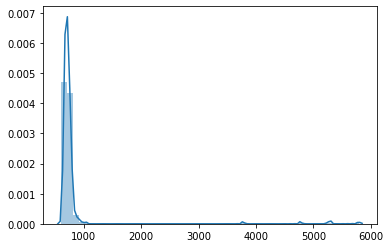

256
discrimination_losses:
[661.36474609 700.35919189 675.21026611 ...   0.           0.
   0.        ]
residual_losses:
[2403.56347656 2456.73583984 2417.20629883 ...    0.            0.
    0.        ]
total_losses:
[584156.375 584156.375 584156.375 ...      0.         0.         0.   ]
yeh
yeh


In [252]:
sns.distplot(disc_losses[0:256], bins=50);

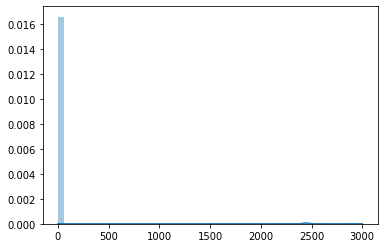

total loss： [ 637.  675.  668.  598.  757.  690.  736.  690.  662.  631.  669.  686.
  839.  690.  691.  689.  648.  715.  719.  741.  694.  664.  682.  679.
  690.  647.  693.  653.  728.  690. 5696.  693.  722.  709.  734.  699.
  751.  695.  676.  685.  696.  654.  611.  660.  632.  699.  731.  715.
  718.  780.  781.  751.  701.  885.  667.  689.  657.  644.  868.  799.
  738.  663.  637.  670.  723.  721.  639.  633.  814.  795.  816.  820.
  698.  653.  743. 1307.  626.  726.  694.  733.  676.  660.  638.  750.
  739.  722.  743.  702.  737.  680.  764.  798.  742.  693.  697.  722.
  735.  724.  704.  719.  684.  758.  747.  796.  748.  769.  705.  818.
  700.  744. 5654.  732.  830.  809.  677.  904.  748.  630.  663.  781.
  755.  659.  738.  679.  776.  739.  711.  731.  707.  772.  665.  707.
  729.  648.  810.  715.  676.  735.  700.  700.  842.  623.  756.  718.
 5164.  713.  692.  654.  758.  709.  663.  748.  695.  701.  632.  640.
  719.  697.  685.  681.  737.  696.  6

yeh
yeh
total loss： [ 624.  757.  699.  818.  750.  787.  774.  688.  722.  749.  644.  759.
  713.  688.  737.  709.  766.  749.  739.  778.  790.  744.  708.  684.
  735.  685.  691.  702.  688.  900.  744.  747.  695.  687.  843.  752.
  672.  709.  665.  863.  725.  642.  657. 1032.  634.  739.  733.  736.
  779.  752.  687. 5307.  711.  717.  723.  783.  712.  726.  686.  716.
  686.  719.  794.  704.  690.  714.  698.  784.  714.  650.  731.  736.
  745.  707.  673.  714.  725.  773. 1259.  717.  704.  740.  703.  704.
  739.  680.  649. 5353.  685.  749.  738.  757.  710.  735.  673.  741.
  692.  674.  728.  721.  733.  815.  774.  740.  724.  732.  679.  675.
  722.  712.  767.  717.  680.  795.  783.  717.  673.  695.  725.  856.
  686.  690.  713.  871.  759.  624.  677.  780.  699.  696.  672.  723.
  731.  703.  696.  720.  699.  745.  695.  741.  669.  703.  725.  806.
  728.  703.  726.  725. 6004.  687.  710.  721.  648.  786.  792.  777.
  703.  779.  749.  705.  752. 

In [242]:
sns.distplot(res_losses)

# np.shape(aug_image)

In [60]:
x = aug_image_list
x = x.to(device)
z = torch.randn(256, 128).to(device) #乱数を指定
z = z.view(z.size(0), z.size(1), 1, 1)
z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)

In [61]:
fake_img.size()

torch.Size([256, 3, 32, 32])

In [62]:
x.size()

torch.Size([256, 3, 32, 32])

In [63]:
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _, discrimination_loss = Anormaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))
        print(torch.sum(discrimination_loss))

epoch 0 || loss_total:621013 
tensor(608663.8125, device='cuda:0', grad_fn=<SumBackward0>)
epoch 1000 || loss_total:415427 
tensor(475754.5312, device='cuda:0', grad_fn=<SumBackward0>)
epoch 2000 || loss_total:384761 
tensor(441171.3750, device='cuda:0', grad_fn=<SumBackward0>)
epoch 3000 || loss_total:364954 
tensor(420607.8438, device='cuda:0', grad_fn=<SumBackward0>)
epoch 4000 || loss_total:349777 
tensor(402840.0312, device='cuda:0', grad_fn=<SumBackward0>)
epoch 5000 || loss_total:339173 
tensor(390527.5938, device='cuda:0', grad_fn=<SumBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total loss： [1167. 1312. 1128. 1067. 1807. 1052. 1227. 2014.  812. 1294. 1649. 1168.
 1531. 1517. 1439. 1354. 1738. 1032. 1620. 5124. 1663.  853. 1720. 1345.
 1428. 1103. 1866. 1508. 1367. 1673. 1530. 1145. 1151. 2279. 1196.  757.
 1436. 1395. 1633. 3304.  891. 1635. 1007. 1342. 1337. 2709. 1196. 1458.
 1669. 1215. 1480. 1367.  814. 1255. 1960. 1270. 1139. 1382. 1410. 3077.
 2901. 1805. 1521.  691. 1336. 1399. 1371.  793. 1520. 1289.  868.  844.
 1375. 1659. 2432. 1654. 1751. 1006. 1321. 1354. 1181. 2013. 1261.  865.
 1758. 1136. 1493. 2148. 1689. 1849. 1285. 1042. 1164. 1341. 1017. 2001.
  823. 1406.  966. 1101. 1325. 1610. 1032. 4196. 2375. 1403. 1225. 1915.
 1296. 1128. 1848.  979. 1643. 1346. 1512. 1295. 1180. 1570. 1372. 1120.
 2751. 1480. 1577.  753. 2677. 1057. 2096. 1953. 1754. 1709. 2946. 1667.
 1002.  989. 1249. 1045.  824. 1743. 2721. 1472. 1831. 1235. 1136. 1616.
 1629.  981. 1174. 1549. 1359. 2360. 1502. 1073. 1153. 2095. 2040. 1815.
 1285. 1061. 1275. 1268. 1140. 1702. 12

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


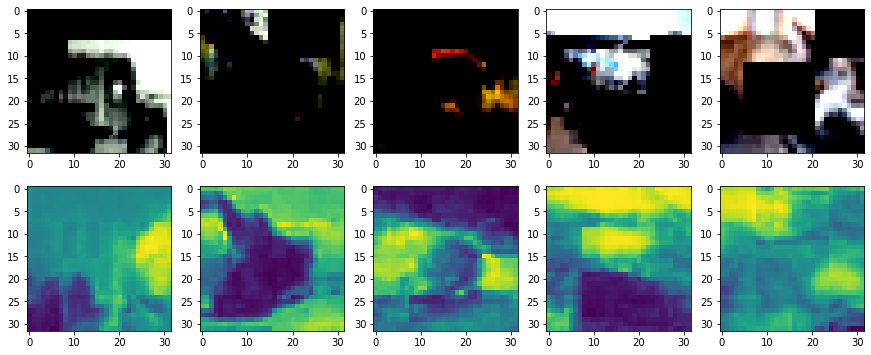

In [94]:
# 画像を生成
fake_img = G_update(z)

# 損失を求める
loss, loss_each, residual_loss_each, discrimination_loss = Anormaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
discrimination_loss = discrimination_loss.cpu().detach().numpy()
print("discrimination loss：", np.round(discrimination_loss, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
tmp = np.where(discrimination_loss < 1000)[0]
np.random.shuffle(tmp)

for i in range(0, 5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    #plt.imshow(x[i].cpu().detach().numpy().reshape(3, 32, 32).transpose(1, 2, 0))
    plt.imshow(x[tmp[i]].cpu().detach().numpy(). reshape(3, 32, 32).transpose(1, 2, 0))

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    #plt.imshow(fake_img[i][0].cpu().detach().numpy())
    plt.imshow(fake_img[tmp[i]][0].cpu().detach().numpy())
    plt.savefig('easy_aug_vs_recon.png')

In [15]:
if not tf.gfile.Exists(output_base_dir):
    tf.gfile.MakeDirs(output_base_dir)

In [53]:
data = load_dataset()

In [77]:
tf.logging.info("*****Processing supervised data *****")
proc_and_dump_sup_data(data["train"], "train", sup_size=-1)
proc_and_dump_sup_data(data["test"], "test")

INFO:tensorflow:*****Processing supervised data *****
INFO:tensorflow:>>saving 50000 train examples to preprocess_test_output/train-full.tfrecord
INFO:tensorflow:saved 50000 examples to preprocess_test_output/train-full.tfrecord
INFO:tensorflow:>>saving 10000 test examples to preprocess_test_output/test.tfrecord
INFO:tensorflow:saved 10000 examples to preprocess_test_output/test.tfrecord


In [78]:
tf.logging.info("*****Processing unsupervised data *****")
tf.logging.info("using random seed {:d} for shuffling data".format(random_seed))
np.random.seed(random_seed)

for aug_copy_num in range(10):
    tf.logging.info(">>processing and copy # {}".format(aug_copy_num))
    proc_and_dump_unsup_data(data["train"], aug_copy_num)

INFO:tensorflow:*****Processing unsupervised data *****
INFO:tensorflow:using random seed 9122 for shuffling data
INFO:tensorflow:>>processing and copy # 0
INFO:tensorflow:trans_list: ['Invert', 'Cutout', 'Sharpness', 'AutoContrast', 'Posterize', 'ShearX', 'TranslateX', 'TranslateY', 'ShearY', 'Rotate', 'Equalize', 'Contrast', 'Color', 'Solarize', 'Brightness']
INFO:tensorflow:saved 50000 examples to preprocess_test_output/unsup-0.tfrecord
INFO:tensorflow:>>processing and copy # 1
INFO:tensorflow:trans_list: ['Invert', 'Cutout', 'Sharpness', 'AutoContrast', 'Posterize', 'ShearX', 'TranslateX', 'TranslateY', 'ShearY', 'Rotate', 'Equalize', 'Contrast', 'Color', 'Solarize', 'Brightness']


KeyboardInterrupt: 

In [1]:
def get_trans_list():
    trans_list = [
        'Invert', 'Cutout', 'Sharpness', 'AutoContrast', 'Posterize',
        'ShearX', 'TranslateX', 'TranslateY', 'ShearY', 'Rotate',
        'Equalize', 'Contrast', 'Color', 'Solarize', 'Brightness']
    return trans_list

#ありうるpolicyをすべて返す.
def randaug_policies():
  trans_list = get_trans_list()
  tf.logging.info("trans_list: %s", str(trans_list))
  op_list = []
  for trans in trans_list:
    for magnitude in range(1, 10):
      op_list += [(trans, 0.5, magnitude)]
  policies = []
  for op_1 in op_list:
    for op_2 in op_list:
      policies += [[op_1, op_2]]
  return policies

# 一度AnoGANについて考える

In [118]:
no_loss = loss
no_residual = residual_loss
no_disc = discrimination_loss

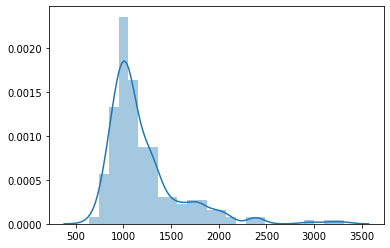

In [119]:
sns_plot = sns.distplot(discrimination_loss.cpu().detach().numpy());
fig = sns_plot.get_figure()
fig.savefig("notrotcarsgraph.png")

In [145]:
#飛行機の画像を回転させてanoganに噛ませる
def _rotate_impl(pil_img, level, _):
    degrees = int_parameter(level, 30)
    if random.random() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees)

PARAMETER_MAX = 10
def int_parameter(level, maxval):
    return int(level * maxval / PARAMETER_MAX)

def float_parameter(level, maxval):
  return float(level) * maxval / PARAMETER_MAX

def _shear_x_impl(pil_img, level, img_shape):
  level = float_parameter(level, 0.3)
  if random.random() > 0.5:
    level = -level
  return pil_img.transform((img_shape[0], img_shape[1]),
                           Image.AFFINE,
                           (1, level, 0, 0, 1, 0))

def rotation_maker(img, numpy=False):
    tmp_img = img.cpu().detach().numpy()
    array = np.asarray(((tmp_img + 1) * 128).astype("i").transpose(1, 2, 0))
    img = Image.fromarray(np.uint8(array))
    rotated_img = _rotate_impl(img, 10, _)
    rotated_img = _shear_x_impl(rotated_img, 10, _)
    rotated_np = np.asarray(rotated_img).astype("f").transpose(2, 0, 1) / 128 - 1.0
    if numpy:
        return rotated_np
    else:
        return rotated_img

In [148]:
!mkdir 'rotated_images/rotated_sheared_1112'

In [149]:
#既にデータ作成済みの場合はここをFalseにする.
making_rotated_imges = True
if making_rotated_imges:
    for i in range(256):
        rotated_img = rotation_maker(imges[0][i], numpy=False)
        rotated_img.save('rotated_images/rotated_sheared_1112/' + str(i) + '.png')

In [151]:
!mv rotated_images/rotated_sheared_1112 rotated_images/rotated_1112/

In [153]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215841, 0.44653091),
                             (0.24703223, 0.24348513, 0.26158784))])

rotated_dataset = datasets.ImageFolder(root='rotated_images/rotated_1112', transform=transform)
rotated_loader = torch.utils.data.DataLoader(rotated_dataset, 
                                                      batch_size=256, shuffle=True, num_workers=4)

In [154]:
rotated_imges[0].size()

torch.Size([256, 3, 32, 32])

In [157]:
rotated_batch_iterator = iter(rotated_loader)
rotated_imges = next(rotated_batch_iterator) 

KeyboardInterrupt: 

In [156]:
#異常検知に用いる画像を表示してみる(今回は, ランダムに回転させた飛行機)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(rotated_imges[0][i].numpy().transpose(1, 2, 0));

KeyboardInterrupt: 

In [126]:
rotated_x = rotated_imges[0][0:256]
rotated_x = rotated_x.to(device)
z = torch.randn(256, 128).to(device) #乱数を指定
z = z.view(z.size(0), z.size(1), 1, 1)
z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)

In [127]:
rotated_x.size()

torch.Size([256, 3, 32, 32])

In [128]:
for epoch in range(5000+1):
    rotated_fake_img = G_update(z)
    loss, _, residual_loss, discrimination_loss = Anormaly_score(rotated_x, rotated_fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))
        print(torch.sum(discrimination_loss))

epoch 0 || loss_total:903381 
tensor(513438.2500, device='cuda:0', grad_fn=<SumBackward0>)
epoch 1000 || loss_total:766182 
tensor(406045.2188, device='cuda:0', grad_fn=<SumBackward0>)
epoch 2000 || loss_total:738015 
tensor(376566., device='cuda:0', grad_fn=<SumBackward0>)
epoch 3000 || loss_total:719698 
tensor(355868.3125, device='cuda:0', grad_fn=<SumBackward0>)
epoch 4000 || loss_total:706264 
tensor(341230., device='cuda:0', grad_fn=<SumBackward0>)
epoch 5000 || loss_total:697723 
tensor(331614.2500, device='cuda:0', grad_fn=<SumBackward0>)


In [129]:
import seaborn as sns

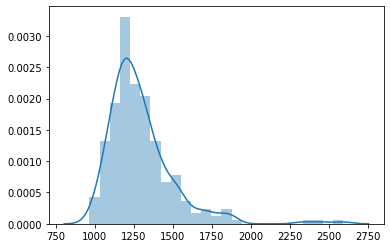

In [130]:
sns.distplot(discrimination_loss.cpu().detach().numpy())
fig = sns_plot.get_figure()
fig.savefig("rotcarsgraph.png")

In [131]:
rot_loss = loss
rot_residual = residual_loss
rot_disc = discrimination_loss

In [137]:
sns.jointplot(no_disc.cpu().detach().numpy(), rot_disc.cpu().detach().numpy());

NameError: name 'no_disc' is not defined

確かに, rotさせたときのdiscrimination lossは悪化しているが, residual lossとかと比べて飛び抜けてヤバいわけじゃない(つまりロバスト)

# Efficient GANの実装